<a href="https://colab.research.google.com/github/mahidhiman12/Deep_learning_with_PyTorch/blob/main/6_PyTorch_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is a custom datasets?
- A custom dataset is a collection of data that a user or organization creates, defines, and tailors to their specific needs, rather than using a pre-existing, general-purpose dataset

- PyTorch Domain Libraries:
    - TorchVision - is this a photo of pizza or sushi ?
    - TorchText - Are these reviews positive or negative ?
    - TorchAudio - What song is playing ?
    - TorchRec - How do we recommend similar products?

Different domain libraries contain data loading functions for different data sources

- What we are going to cover ⁉
    - Getting custom dataset with PyTorch
    - Becoming one with the data (preparing and visualizing)
    - Transforming data for use with a model
    - Loading custom data with pre-built functions and custom functions
    - Building FoodVision Mini to classify images
    - Comparing models with and without data augmentation
    - Making predictions on custom data

In [1]:
# Import PyTorch
import torch
from torch import nn
torch.__version__

'2.8.0+cu126'

In [2]:
# set device agnostic code
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

1. Get data

- Our dataset is a subset of the Food101 dataset which is 101 dfferent classes of food and 1000 images per class (750 training , 250 testing)

- Our dataset starts with 3 classes of food (pizza , steak , sushi) and only 10% of the images (~75 training , ~25 testing)

- When starting out with ML projects . its important to try things on a small scale and then increase the scale when necessary

- The whole point is to speed up how fast you can experiment

In [3]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnt exist , download it and prepare it ...
if image_path.is_dir():
  print(f"{image_path} directory already exists .. skipping download")
else:
  print(f"{image_path} does not exist , creating one..")
  image_path.mkdir(parents = True , exist_ok = True)

# Download the data
zip_file_path = data_path / "pizza_steak_sushi.zip"
with open(zip_file_path, 'wb') as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza , steak , sushi data.. ")
  f.write(request.content)

# unzip pizza steak sushi file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  print("Unzipping data file" )
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist , creating one..
Unzipping data file


## 2. Exploring and Preparing the data


In [4]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents. """
  for dirpath , dirnames , filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images , lets open the image with Python's PIL
5. We will then show the image and print metadata



In [7]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path : data/pizza_steak_sushi/test/pizza/2111981.jpg
Image class : pizza
Image height : 512
Image width : 512


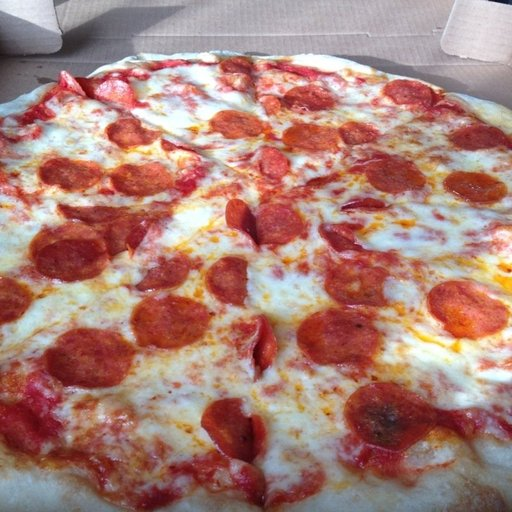

In [8]:
import random
from PIL import Image

# seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)


# 3. Get image class from path name (the image class is the name of directory where the image is stored)
image_class = random_image_path.parent.stem


# 4. open image using PIL
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img

### visualizing using matplotlib

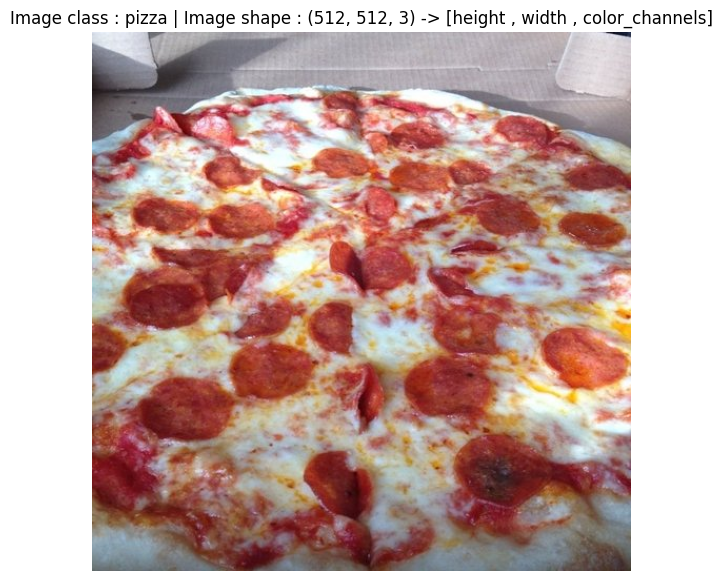

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# turn image into array
img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape} -> [height , width , color_channels]")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case , numerical representation)
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` , we will call these `Dataset` and `DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets , transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation.

Transforms are common image transforms available in `torchvision.transforms` module.

They can be chained together using `Compose`

the transforms we want to perform are:

    1. resizing

    2. flip the image (data augmentation)

    3. Turn into tensor

In [11]:
# write a transform for image
data_transform = transforms.Compose([
    # resize
    transforms.Resize(size=(64,64)),
    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # turn the image into a torch.tensor
    transforms.ToTensor()
])

In [12]:
print(f"Img shape before transform : {img.size}")
print(f"Img shape after transform : {data_transform(img).shape}")


Img shape before transform : (512, 512)
Img shape after transform : torch.Size([3, 64, 64])


### visualise transformed image

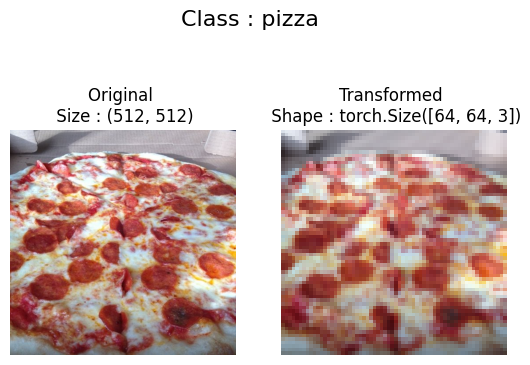

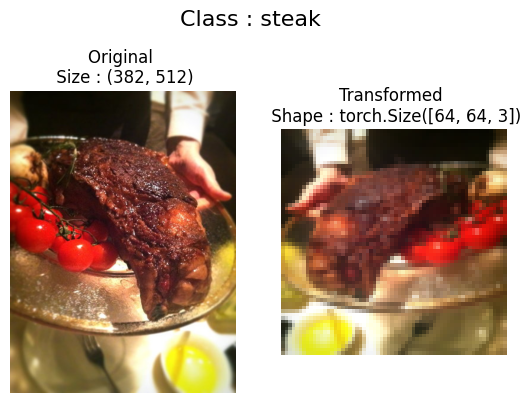

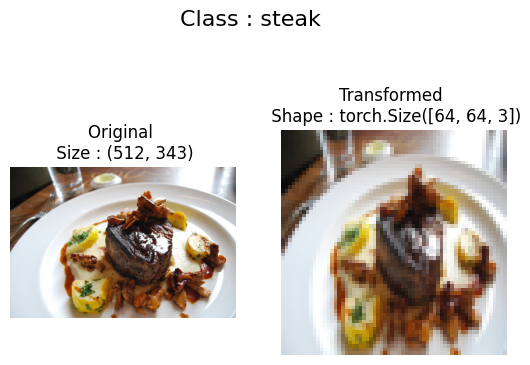

In [13]:
def plot_transformed_images(image_paths,transform,n=3,seed=42):
  """ Selects random images from a path of images and loads/transforms them then
      plots the original vs the transformed version
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths , k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig , ax = plt.subplots(nrows = 1 , ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size : {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      # permute changes order , bcs rn its (3,64,64) that will be a shape error
      # we can take 3 at the last by shuffling indices with permute
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Shape : {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class : {image_path.parent.stem}" , fontsize = 16)

plot_transformed_images(image_paths = image_path_list, transform=data_transform)

SEE that the pictures are more pixelated now because its 64,64 now when earlier it was 512 , 512

- After passing through the data transform these pictures are now
    - resized
    - flipped
    - converted to Tensors.

The most important thing will be does it still look like that to our model?

- Now , there is less information encoded in this image. So our model will compute faster on images of this size . However , we may loose some performance because not as much information is encoded as the original image

- Size is something that you can control . You can set it to be a hyper parameter. You can tune the size to see if it improves your model.

## 4. Option 1 : Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [14]:
from typing_extensions import dataclass_transform
from torchvision import datasets
train_data  = datasets.ImageFolder(root = train_dir,
                                   transform = data_transform, # transform for data
                                   target_transform = None) # Transform for target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data , test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [42]:
# index on the train_data Dataset to get a single image and label
# rndm_idx = torch.randint(0, len(train_data), size=())
# img , label = train_data[rndm_idx][0] , train_data[rndm_idx][1]
img , label = train_data[0][0] , train_data[0][1]
img
print(f"Image Tensor:\n{img}")
print(f"Image shape : {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label : {label} -> {class_names[label]}")

Image Tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

New shape : torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

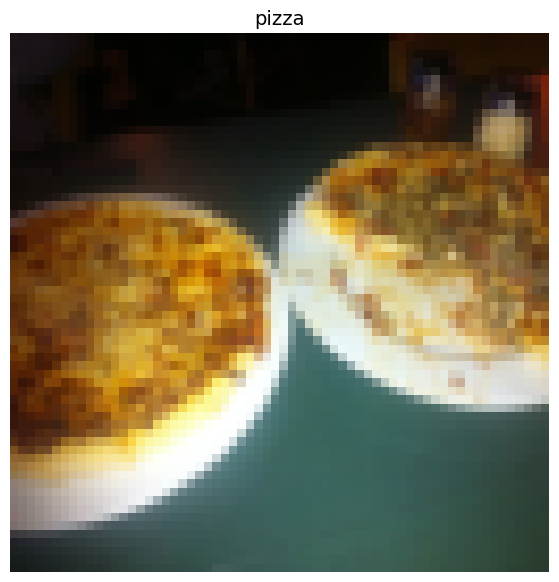

In [43]:
# plot using matplotlib
# rearrage the order dimensions because matplotlib likes color channels last
# [3, 64, 64] -> [64, 64, 3]

img_permute = img.permute(1,2,0)
print(f"New shape : {img_permute.shape}")

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label] , fontsize = 14)

### 4.1 Turning our image datasets into PyTorch DataLoaders

A DataLoader is going to help us turn our Dataset's into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time

In [45]:
import os
os.cpu_count()

2

In [54]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size= BATCH_SIZE,
                              num_workers =1,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                              batch_size= BATCH_SIZE,
                              num_workers =1,
                              shuffle=False)

# num workers -> the more the better , can set it to os.cpu_count()
# shuffle = False for test_dataloader bcs that if we want to evaluate our models
# later on , our test data set is always in the same order.

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c4334485220>,
 <torch.utils.data.dataloader.DataLoader at 0x7c43344861e0>)

In [55]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [56]:
len(train_data) , len(test_data)

(225, 75)

> NOTE : The next() function in PyTorch is primarily used in conjunction with iter() to retrieve individual batches of data from a DataLoader.

In [60]:
img , label = next(iter(train_dataloader))
print(f"image shape : {img.shape} -> [batch_size , c , h , w]")
print(f"label shape : {label.shape}")

image shape : torch.Size([1, 3, 64, 64]) -> [batch_size , c , h , w]
label shape : torch.Size([1])


Till now , we saw how to get our data from our data folder . We have got images of different food data here. And we are trying to get it into tensor format. So we have seen how to do that
with an existing data loader helper function or data set function in image folder.

However , what if image folder didnt exist? And we need to write our own custom data loading function.

- So lets replicate the functionality of image folder by creating our own data loading class.

So we want a few things ,
- Want to be able to load images from a file

- We want to be able to get the class names as a list from our loaded data

- We want want to be able to get our class names as a dictionary as well.

So the whole goal is to start writing a class thats capable of loading data from the data folder into tensor format , capable of being used with PyTorch's data loader class , like we have done before

Pros:
- Can create a `Dataset` out of almost anything
- Not limited to PyTorch pre-built `Dataset` functions

Cons:
- Even though you could create `Dataset` out of almost anything , it doesnt mean it will work
- Using a custom Dataset often results in us writing more code , which could be more prone to errors or performance issues

In [ ]:
import os
import pathlib
import torch

from PIL import Image